# Analysis of single cell RNA sequencing data
---
by Anton Crombach, anton.crombach@inria.fr

This notebook contains a rather straightforward analysis of a single cell RNA sequencing data set. It closely follows the steps set out by Satija *et al.* (2015), but instead of using their R package `seurat`, I use the Python package `scanpy` in a Jupyter notebook.

The analysis is divided into four major sections: 

1. Preprocessing,
2. Dimension reduction and clustering, 
3. Analysis of marker genes,
4. Zooming in on specific clusters.

Before starting with the actual analysis, please take into account the following references:

- Repository of `scanpy`, <https://github.com/theislab/scanpy/tree/master/scanpy>
- Documentation of `scanpy`, <https://scanpy.readthedocs.io/en/stable/>
- Accompanying article, <https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0>
- R package `seurat`, <https://satijalab.org/seurat/>
- Its original publication, <https://www.nature.com/articles/nbt.3192>
- And do not forget that additional tutorials are available at <https://scanpy.readthedocs.io/en/stable/tutorials.html>.

Finally, I use two kinds of text boxes to draw your attention. *Blue* boxes contain general information that is not strictly related to the analysis, but reading them makes you a more complete scientist. *Yellow* boxes signal key points in the analysis where you can modify variables or parameters and see how these affect the results.

In [1]:
import anndata as ad
!h5ls '/home/shared-data/l5_all.h5ad'

X                        Group
obs                      Dataset {160796}
uns                      Group
var                      Dataset {27998}


In [2]:
adata=ad.read_h5ad(filename='/home/shared-data/l5_all.h5ad')

## Getting ready, importing packages

In [3]:
# Operating System functionality, especially for traversing directory structures
import os
# Specialized container datatypes, i.e. specialized versions of lists, dictionaries, etc.
import collections as coll
# Date and time functions, useful for timestamping file names of figures.
import datetime
# Functional programming tools.
import itertools as itt
# Pretty-printing text by wrapping and filling lines.
import textwrap as tw

# Well-known package for n-dimensional arrays, numerical functions, linear algebra, etc.
import numpy as np
# Data analysis package.
import pandas as pd
# "Default" plotting package of Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
# Matplotlib colours module.
import matplotlib.colors as mpcol
# Package improving Matplotlib's default plot style.
import seaborn as sns

# Single Cell Analysis in Python
import scanpy as sc

<div class="alert alert-block alert-info">
    Upon importing packages, <em>h5py</em> gives a <em>FutureWarning</em>. This is a known (innocent) issue that does not impact our analysis. It can be safely ignored.
</div>

Set the level of chattiness of scanpy functions (0=errors, 1=warnings, 2=info, 3=hints, 4=details, 5 etc.)

In [4]:
sc.settings.verbosity = 3

Throughout the notebook, one can use the paths below to retrieve and store data/figures.

In [5]:
# Input
DATA_PATH = "/home/shared-data/"
PIRIF_PATH = os.path.join(DATA_PATH, "filtered_feature_bc_matrix/")
TF_LIST_FNAME = os.path.join(DATA_PATH, "mm_transcription_factors/mm_tf_list.html")

# Output
FIGURES_PATH = "/home/jovyan/figures"

In [6]:
# Input
#DATA_PATH = "../../data"
#PIRIF_PATH = os.path.join(DATA_PATH, "PiriF_SC_v3/outs/filtered_feature_bc_matrix/")
#TF_LIST_FNAME = os.path.join(DATA_PATH, "mm_transcription_factors/mm_tf_list.html")

# Output
#FIGURES_PATH = "figures"

Make a *figures* directory if it does not exist yet.

In [7]:
try:
    os.mkdir(FIGURES_PATH)
except FileExistsError:
    print("'{}' already exists...".format(FIGURES_PATH))
    pass

'figures' already exists...


<div class="alert alert-block alert-info">
    The one-line function <code>timestamp</code> below is useful for adding a unique timestamp to output file names. I use it mainly to avoid overwriting old versions of the same figure. The downside is, of course, that you can end up with many many files in a folder.
</div>

In [8]:
def timestamp():
    return datetime.datetime.now().strftime('%Y-%m-%d_%Hh%M')

## Reading in a big matrix of mRNA expression data

In [9]:
def read_data(input_path):
    """
    Read in data given a directory. As 10X Genomics data always consists of 
    the same three files, scanpy is kind enough to provide a function that 
    deals with these. As a side-effect, we report which genes are found 
    multiple times.
    
    Return the AnnData object `data`.
    """
    data = sc.read_10x_mtx(input_path, make_unique=False, cache=False)

    if sc.settings.verbosity > 2:
        # Print all genes that are present more than once as (name: found x times)
        print("\nDuplicate gene names with their nr of occurrences:\n") 
        print("\n".join(tw.wrap(";\t".join("{0}: {1}".format(name, ndup)
                  for name, ndup in itt.takewhile(lambda x: x[1] > 1, 
                      coll.Counter(data.var_names).most_common())), 75)))

    # Add '-1', '-2' etc. to names to make them unique
    data.var_names_make_unique()
    return data

Please note that the function `read_data` calls `.var_names_make_unique`.

In [10]:
data = read_data(PIRIF_PATH)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.



Duplicate gene names with their nr of occurrences:

Il11ra2: 3;     Sept2: 2;       Kiss1: 2;       Zc3h11a: 2;     Gm16701: 2;
Hoxd4: 2;       Gm2464: 2;      Vmn2r7: 2;      Ccl21b: 2;      Ccl19: 2;
Ccl21a: 2;      Gm28710: 2;     Jakmip1: 2;     Gm3286: 2;      Gm16499: 2;
Zfp865: 2;      Olfr290: 2;     Aldoa: 2;       Dpep2: 2;       St6galnac2:
2;  Hgs: 2; Vmn1r216: 2;    Nnt: 2; Gm35558: 2;     Ighv5-8: 2;
Ighv1-13: 2;    Gcat: 2;        Pick1: 2;       Atp5o: 2;       Pcdha11: 2;
Nudt8: 2;       Lbhd1: 2;       Ints5: 2;       Ccl21c: 2;      Ccl27: 2


I actually do not know why duplicate gene names pop up... Surely 10X Genomics mentions it somewhere in their documentation.

<div class="alert alert-block alert-info">
    It is a good habit to routinely check what your <var>AnnData</var> object looks like. A simple <code>print</code> command often gives enough information, as you can see below.
</div>

Reminder: *n_obs* = cells, *n_vars* = genes

In [11]:
print(data)

View of AnnData object with n_obs × n_vars = 3675 × 31053 
    var: 'gene_ids', 'feature_types'


<div class="alert alert-block alert-warning">
<b>Using Mouse Brain data </b> 
    </br>
    </br>
    The section below provides a starting point for your exploration of the code using the data provided from mousebrain.org

</div>

## Accessing and subsetting MouseBrain.org data

Load the provided mouse brain data. This will take about a minute

In [12]:
import  anndata as ad
mbdata=ad.read_h5ad(filename=os.path.join(DATA_PATH, 'l5_all.h5ad'))

This loads the entire dataset in memory and now we shall show you how to subset the data based on the cluster alongwith some additional tips.
First we get some basic information about the dataset. 

In [13]:
mbdata

AnnData object with n_obs × n_vars = 160796 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'C

As you can see the command provides some basic information about the dataset, mainly:
* n_obs -- the number of rows: which is also the number of cells
* n_vars -- the number of columns: Which is alss the number of genes

Furthermore, a list of all the associated annotation variables for a given cell is provided. For more information on how the AnnData object is structured see this link https://anndata.readthedocs.io/en/latest/anndata.AnnData.html

In this case we want to subset the data based on the putative clusters provided and the variable which contains this `ClusterName`. 

Let's take a quick peek at what are the different categories within `ClusterName`

In [14]:
mbdata.obs['ClusterName'].cat.categories

Index(['ABC', 'ACBG', 'ACMB', 'ACNT1', 'ACNT2', 'ACOB', 'ACTE1', 'ACTE2',
       'CBGRC', 'CBINH1',
       ...
       'TEINH18', 'TEINH19', 'TEINH20', 'TEINH21', 'VECA', 'VECC', 'VECV',
       'VLMC1', 'VLMC2', 'VSMCA'],
      dtype='object', length=265)

Obviously you would look up how to print all the categories in a pandas dataframe, but to put things in context these names are the equivalent to the *symbol* column in the celltypes table here http://mousebrain.org/celltypes/

Now we finally create a subset of our data and for brevity we will choose to include only clusters from  *TEGLU15* , *TEGLU16* and *TEGLU17*. The way this is done is by subsetting the `mbdata` object by providing a list of *cluster names*

In [15]:
mbdata_subset=mbdata[mbdata.obs['ClusterName'].isin(['TEGLU15', 'TEGLU16','TEGLU17']),]

And we see that this has worked by checking the categories for the subset

In [16]:
mbdata_subset.obs['ClusterName'].cat.categories

Index(['TEGLU15', 'TEGLU16', 'TEGLU17'], dtype='object')

Finally, let's remove the `mbdata` object to free up some memory for the analysis

In [17]:
del mbdata

In [18]:
del mbdata_subset

<div class="alert alert-block alert-warning">
<b>End saection Using Mouse Brain data </b> 
</div>

## Removing any cells that are probably dying

We identify dying cells by having a high fraction of mitochondrial genes.

In [19]:
mito_genes = [name for name in data.var_names if name.startswith(('mt-', 'MT-'))]

For each cell compute fraction of counts in mito genes vs. all genes. The `.A1` is only necessary because X is a sparse matrix. It transforms to a dense matrix (2D array) after summing.

In [20]:
data.obs['frac_mito'] = np.sum(data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1

Trying to set attribute `.obs` of view, making a copy.


Add the total counts per cell as observations-annotation to data

In [21]:
data.obs['n_counts'] = data.X.sum(axis=1).A1

Computing how many genes are expressed in each cell

In [22]:
data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1

Computing in how many cells a gene is found. At the moment I do not use this info in the analysis.

In [23]:
data.var['n_cells'] = np.sum(data.X > 0, axis=0).A1

<div class="alert alert-block alert-warning">
Modify the cut-off threshold to see how it affects the figure below.
</div>

In [24]:
MITO_CUTOFF = 0.1

Below we create a figure with four plots. The top row contains two plots relating mitochondrial expression against total expression in the cell (top-left) and against the number of expressed genes per cell (top-right).



Some info on the arguments used in the various functions:

- in `plt.subplots`, `figsize` is expressed in inches.
- in `sns.scatterplot`, `s` = size of dots, and `alpha` = transparency level of a dot.

<div class="alert alert-block alert-info">
    I prefer to use <var>seaborn</var> (sns) plotting functions as I can easily adjust them for a good looking plot. Alternatively, <var>scanpy</var> has its own scatterplot function, named <var>sc.pl.scatter</var>, as you can see in the commented-out code.
</div>

<div class="alert alert-block alert-warning">
    The variable <var>min_count</var> allows us to temporarily filter out the genes that are detected in 0 or few cells. Modify it and see how this affects the data.
</div>

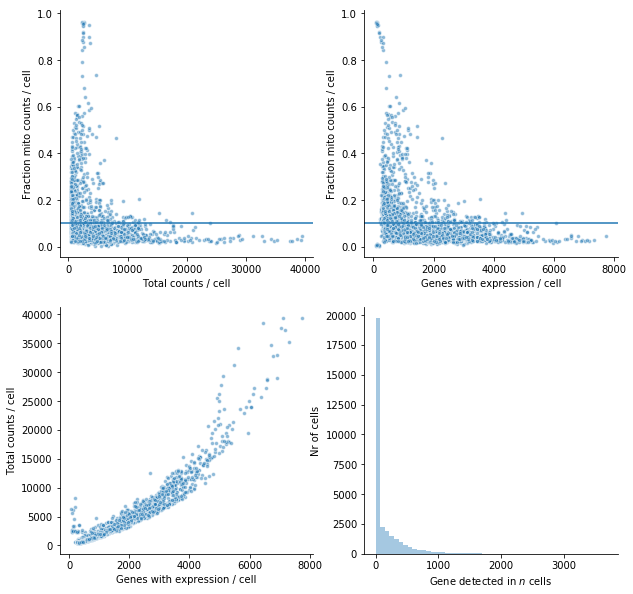

In [25]:
min_count = 0

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10));
sns.despine(fig)

# Plot the fraction of mito expression per total expression in a cell
sns.scatterplot(x=data.obs['n_counts'], y=data.obs['frac_mito'], s=15, alpha=0.5, ax=axs[0, 0]);
axs[0, 0].set(xlabel='Total counts / cell', ylabel='Fraction mito counts / cell');
#sc.pl.scatter(data, x='n_counts', y='frac_mito', ax=axs[0, 0]);
axs[0, 0].axhline(y=MITO_CUTOFF);

# Plot the fraction of mito expression per nr of expressed genes in a cell
sns.scatterplot(x=data.obs['n_genes'], y=data.obs['frac_mito'], s=15, alpha=0.5, ax=axs[0, 1]);
axs[0, 1].set(xlabel='Genes with expression / cell', ylabel='Fraction mito counts / cell');
#sc.pl.scatter(data, x='n_genes', y='percent_mito', ax=axs[0, 1]);
axs[0, 1].axhline(y=MITO_CUTOFF);

# Plot nr of expressed genes against total expression
sns.scatterplot(x=data.obs['n_genes'], y=data.obs['n_counts'], s=15, alpha=0.5, ax=axs[1, 0])
axs[1, 0].set(xlabel='Genes with expression / cell', ylabel='Total counts / cell');
#sc.pl.scatter(data, x='n_genes', y='n_counts', ax=axs[1, 0]);

# Plot distribution of nr of cells in which a gene was (detected to be) expressed
aux = data.var['n_cells'][data.var['n_cells'] >= min_count]
sns.distplot(aux, bins=50, kde=False, ax=axs[1, 1]);
axs[1, 1].set(xlabel='Gene detected in $n$ cells', ylabel='Nr of cells');

#### Save the figure as a PDF

In [26]:
fig.savefig(os.path.join(FIGURES_PATH, 'mito_quality_control.pdf'))

<div class="alert alert-block alert-info">
    If you prefer to generate a PNG plot, use the parameter <var>dpi</var> ("dots per inch" ~ resolution) to change the quality of the image. For screens, <code>dpi=90</code> is usually sufficient. For printing, set <code>dpi=300</code> or higher.
</div>

In [27]:
fig.savefig(os.path.join(FIGURES_PATH, 'mito_quality_control.png'), dpi=90)

#### Observations:

- There are many genes that are detected in very few cells.
- In fact, ~10k genes (of a total of ~30k) are not detected in any cell.
- Conversely, there are a few genes detected in many cells.

How many cells do we classify as dying?

In [28]:
n_dying = np.sum(data.obs['frac_mito'] >= MITO_CUTOFF)
n_alive = np.sum(data.obs['frac_mito'] < MITO_CUTOFF)

print("Dying: {}\nAlive: {}".format(n_dying, n_alive))

Dying: 1513
Alive: 2162


We remove cells that have a high fraction of mito genes.

In [29]:
data = data[data.obs['frac_mito'] < MITO_CUTOFF, :]

Let's throw out the cells with very few genes and the genes detected in very few cells

In [30]:
sc.pp.filter_cells(data, min_genes=8)
sc.pp.filter_genes(data, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


filtered out 12601 genes that are detectedin less than 3 cells


<div class="alert alert-block alert-warning">
    Playing with the values for <var>min_genes</var> and <var>min_cells</var> can have surprising effects on the analysis results in the rest of the notebook. I suggest you do not touch the current values during the first analysis. Once you have gone through the entire notebook, feel free to modify them and see how they change the outcome.
</div>

## Looking at highly expressed genes

<div class="alert alert-block alert-warning">
    Listing the most expressed genes. Change the value of `top` to get more or less genes.
</div>

In [31]:
top = 10

Sum over all the genes to compute their total expression across cells.

In [32]:
maxs = data.X.sum(axis=0).A1

Partially sort the list of total expression `maxs` and take the indices of the `top` most expressed genes.

In [33]:
indices = np.argpartition(maxs, kth=len(maxs)-top)[-top:]

Use these indices to retrieve the gene names, sort them in alphabetical order, and convert the output to a simple list

In [34]:
most_expressed = data.var_names[indices].sort_values().tolist()
most_expressed

['Apoe',
 'Cst3',
 'Malat1',
 'Plp1',
 'Tmsb4x',
 'mt-Atp6',
 'mt-Co1',
 'mt-Co3',
 'mt-Cytb',
 'mt-Nd1']

Funnily enough, mitochondrial genes ('mt-') are amongst the most highly expressed ones!

## Looking at highly expressed transcription factors

In [35]:
def read_known_transcription_factors():
    """
    Get a list of transcription factor (TF) gene names from a file downloaded 
    from http://genome.gsc.riken.jp/TFdb/tf_list.html
    
    The code looks complicated, but it simply opens the file and parses all 
    the table rows for the gene names.
    """
    with open(TF_LIST_FNAME) as infile:
        return set([line.split('<td')[3][1:-5] for line in infile if line.startswith('<tr>')])

In [36]:
TFs = read_known_transcription_factors()

Filtering the transcription factor list to make sure we only have gene names that are also found in the data.

In [37]:
transfac_genes = [name for name in data.var_names if name in TFs]

And which are the most expressed transcription factors? Let's look at the top 10.

In [38]:
top = 10

Instead of summing over all genes in the data, here we only sum over the transcription factors. The rest of the code has been commented on above.

In [39]:
maxs = data[:, transfac_genes].X.sum(axis=0).A1
indices = np.argpartition(maxs, kth=len(maxs)-top)[-top:]
most_expressed_tfs = data[:, transfac_genes].var_names[indices].sort_values().tolist()
most_expressed_tfs

['Ank2',
 'Fos',
 'Jun',
 'Junb',
 'Klf2',
 'Ptma',
 'Rora',
 'Sirt2',
 'Taf1c',
 'Tcf4']

Look at gene expression across cells and save the figure as a PDF.

/opt/conda/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


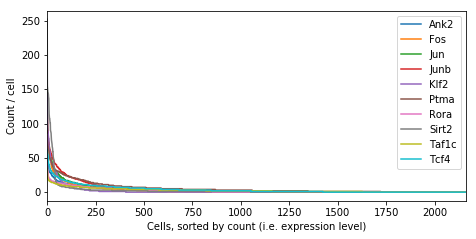

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5))

for gname in most_expressed_tfs:
    # `reverse=True` sorts the data from high to low.
    pd.Series(sorted(data[:, data.var_names == gname].X, reverse=True)).plot(label=gname, ax=ax);

ax.set(xlabel='Cells, sorted by count (i.e. expression level)', ylabel='Count / cell')
ax.legend();

fig.savefig(os.path.join(FIGURES_PATH, 'highly_expressed_transcription_factors.pdf'))

`scanpy` offers a box-whisker visualization. Uncomment & run the code below, if you want to see what it looks like

In [41]:
#sc.pl.highest_expr_genes(data, n_top=20)

# Summary of what we have done so far.

- We have read in the data.
- We removed dying cells by checking for the fraction of expressed mitochondrial genes.
- And we checked which genes and TFs are expressed most.

Now we are ready to reduce the dimensions of the huge, but rather sparse, matrix of mRNA counts, cluster the cells, and visualize these clusters.

# Option: select a subset of cells for analysis

Below I provide a function that allows you to select only those cells that have non-zero expression for a given gene. I do not use this functionality normally, but it can be helpful to focus on specific cells.

In [42]:
def select_cells_expressing_gene(data, gene):
    """Select cells (rows) in the matrix that have nonzero values for the given gene."""
    return data[data[:, gene].X > 0,]

Define your list of favorite genes.

In [43]:
favorite_genes = ['Cux1', 'Rbfox3', 'Reln']

Below I make a (shallow) copy of the data set. In the for-loop we select in each iteration only those cells that express the favorite gene.

In [45]:
fav_data = data
for fg in favorite_genes:
    fav_data = select_cells_expressing_gene(fav_data, fg)

print(fav_data)

View of AnnData object with n_obs × n_vars = 8 × 18452 
    obs: 'frac_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


# Normalization and filtering for genes with variable expression

In [46]:
def normalize_and_log(data, counts=1e4):
    """
    Normalize umi counts to 10k per cell, and take the log of the data.
    """
    data.raw = data
    sc.pp.normalize_per_cell(data, counts_per_cell_after=counts)
    sc.pp.log1p(data)
    return data

def filter_by_expr_dispersion(data, min_mean=0.0, max_mean=100.0, min_disp=0.05,
                              n_bins=50, dry_run=True):
    """
    min_mean: minimal level of gene expression to consider.
    max_mean: maximal level of gene expression.
    min_disp: minimal level of dispersion to consider.
    n_bins: number of bins to divide the distribution of expression levels over. 
            The bins go from low mean expression levels to high ones.
    
    The default parameter values were established through trial and error. They 
    worked for my particular data set, and they will have to be recalibrated for 
    each data set.
    
    Return log expression data.
    """
    old_verbo = sc.settings.verbosity
    # I want lots of feedback from the algorithm
    if dry_run:
        sc.settings.verbosity = 4
        filter_result = sc.pp.highly_variable_genes(data, 
            min_mean=min_mean, max_mean=max_mean, min_disp=min_disp, max_disp=20.0,
            n_bins=n_bins, inplace=False)
    
        # Plot the filtering result, even if I do not find the plots very intuitive.
        sc.pl.highly_variable_genes(filter_result)
        sc.settings.verbosity = old_verbo
        return filter_result
    
    else:
        # Do the actual filtering
        sc.pp.highly_variable_genes(data, 
            min_mean=min_mean, max_mean=max_mean, min_disp=min_disp, max_disp=20.0,
            n_bins=n_bins)
    return data

The function below has as a side effect that the original data is stored in a *raw* attribute of `data`. Check it by inspecting `data` (remember `print`!).

In [47]:
data = normalize_and_log(data)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


<div class="alert alert-block alert-warning">
Modify the number of bins if you get the message that there are many "single genes per bin". It usually means that you should reduce `n_bins`.
</div>

In [48]:
n_bins = 35

<div class="alert alert-block alert-info">
    Before filtering for highly variable genes, make sure to take the logarithm of the data. The function <code>normalize_and_log</code> takes care of this.
</div>

I set `min_mean=0.0` to not lose transcription factors that are expressed at very low levels. And I set `max_mean=10.0` to simply have all the data. An alternative idea could be to focus only on lowly expressed genes, assuming those are more likely to be TFs. This means `max_mean=1.0` or even lower.

extracting highly variable genes
    Gene indices [2148, 17951, 18437] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)


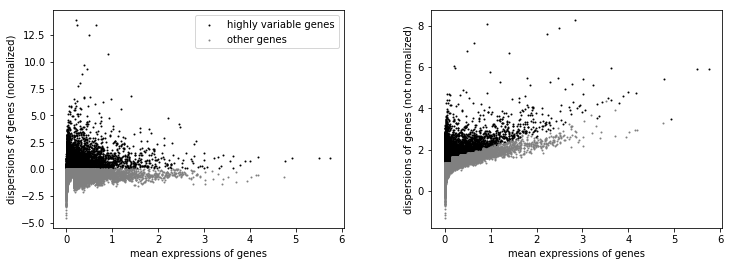

In [49]:
min_mean, max_mean, min_disp = 0.0, 10.0, 0.05
result = filter_by_expr_dispersion(data, min_mean, max_mean, min_disp, n_bins, dry_run=True)

Do the actual filtering, above was just a trial to see what the graphs look like.

In [50]:
data = filter_by_expr_dispersion(data, min_mean, max_mean, min_disp, n_bins, dry_run=False)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<div class="alert alert-block alert-warning">
    Depending on the data set, people regress out certain factors (or not). To know what is best for your specific data set, you simply need to check which regression gives better clustering results... and yes that is a bit dependent on the researcher doing the interpretation.
</div>

In [51]:
#sc.pp.regress_out(data, ['n_counts', 'frac_mito'])
sc.pp.regress_out(data, ['n_counts'])
sc.pp.scale(data)

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use


... storing 'feature_types' as categorical


    finished (0:01:29)


# Dimension reduction

As most people, I first do a Principal Component Analysis (PCA) to reduce the dimensions of the huge data matrix. This is not the only way to deal with single cell RNAseq data. Other approaches include:

- Independent Component Analysis (ICA), which is implemented in the Python package *scikit-learn*
- Iterative Clustering for Identifying Markers (ICIM), as used in the following article <https://www.cell.com/cell/fulltext/S0092-8674(17)31241-2>. The corresponding Python package is found here: <https://github.com/felixhorns/FlyPN>.

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:03)


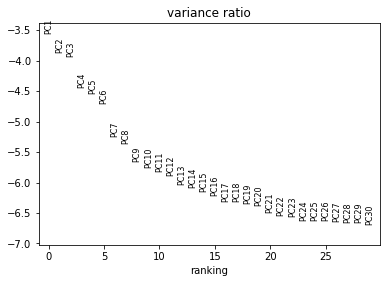

In [52]:
sc.tl.pca(data, n_comps=30, svd_solver='arpack')
sc.pl.pca_variance_ratio(data, log=True, save=True)

On the basis of the variance ratio graph, I pick the n first PCs. The idea is to stop including PCs as the curve flattens.

In [53]:
pcs_used = 23

# Clustering and visualization

In [54]:
def plot_graph(data, seed, dotsize, ax):
    """
    Spring-based projection with pretty colouring of the Louvain clusters.
    """
    # Set nice colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]
    
    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.draw_graph(data, random_state=seed)
    sc.pl.draw_graph(data, color='louvain', size=dotsize, 
        title='Spring-based projection', legend_loc='on data', show=False, ax=ax)
    return data, fig, ax

def plot_umap(data, seed, dotsize, ax):
    """
    UMAP projection and pretty colouring of the Louvain clusters.
    """
    # Colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]
    
    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()    
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.umap(data, random_state=seed)
    sc.pl.umap(data, color='louvain', size=dotsize, 
        title='UMAP projection', legend_loc='on data', show=False, ax=ax)
    return data, fig, ax

def plot_tsne(data, pcs_used, seed, dotsize, ax):
    """
    tSNE projection and colouring of Louvain clusters.
    """
    # Colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]

    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.tsne(data, n_pcs=pcs_used, random_state=seed)
    sc.pl.tsne(data, color='louvain', size=dotsize,
        legend_loc='on data', title='tSNE projection', show=False, ax=ax)
    return data, fig, ax

Calculating the neigborhood graph approximates the high-dimensional manifold on which our cells "live". Next, the Louvain clustering algorithm finds "communities" of cells on the graph.

<div class="alert alert-block alert-warning">
    A low number of neighbors (e.g. nbs=5) will give a more local shape of the manifold, while a high number (e.g. nbs=250) will give a more global shape of the manifold. These numbers are relative to the total number of cells we have; you cannot look at more neighbors than you have cells.
</div>

In [55]:
nbs = 25
sc.pp.neighbors(data, n_pcs=pcs_used, n_neighbors=nbs)
sc.tl.louvain(data)

computing neighbors
    using 'X_pca' with n_pcs = 23
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Prepare a figure to show three 2D projections of the cells and colour them by Louvain communities (=clusters). 
Be careful interpreting the tSNE projection, see <https://distill.pub/2016/misread-tsne/>. Also, note that the `seed` and `dotsize` variables are re-used in all three plots.

computing tSNE
    using 'X_pca' with n_pcs = 23
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:35)


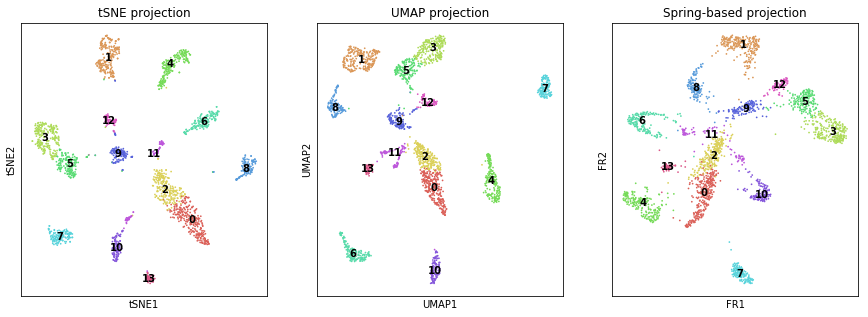

In [56]:
seed = 18
dotsize = 12

fig, axes = plt.subplots(1, 3, figsize=(15, 5.02))

# Plot the "classical" tSNE projection
_ = plot_tsne(data, pcs_used, seed, dotsize, axes[0])

# Plot the UMAP projection, which maintains the distances between clusters better than tSNE
_ = plot_umap(data, seed, dotsize, axes[1])

# Plot a spring-based projection, a classical algorithm to project graphs onto 2D
_ = plot_graph(data, seed, dotsize, axes[2])

<div class="alert alert-block alert-info">
    For those who want to improve their Python coding skills: if you know a function returns a value, but you do not care about it, the convention is to using an underscore (<var> _ </var>) as a variable name. See <a href="https://stackoverflow.com/questions/5893163/what-is-the-purpose-of-the-single-underscore-variable-in-python"> this StackOverflow question and answer</a> for more info.
</div>

In [57]:
fig.savefig(os.path.join(FIGURES_PATH, 'three_projections_with_louvain_clusters_{}.pdf'.format(timestamp())))

# Looking for marker genes

Different statistical tests can be used to compute marker genes, that is genes that define each of the clusters by being differentially expressed. Below I have commented out the `t-test`, because I prefer to use the `logreg` one. The latter is supposed to be a good method, as it is a multivariate test, and the conventional ones are univariate.

In [58]:
#sc.tl.rank_genes_groups(data, 'louvain', method='t-test')
sc.tl.rank_genes_groups(data, 'louvain', method='logreg')

ranking genes


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:03:13)


Create an ugly, but informative plot of top n genes and their scores. It is useful to first plot many genes, as you can easily see how many genes appear to be important for each of the clusters.

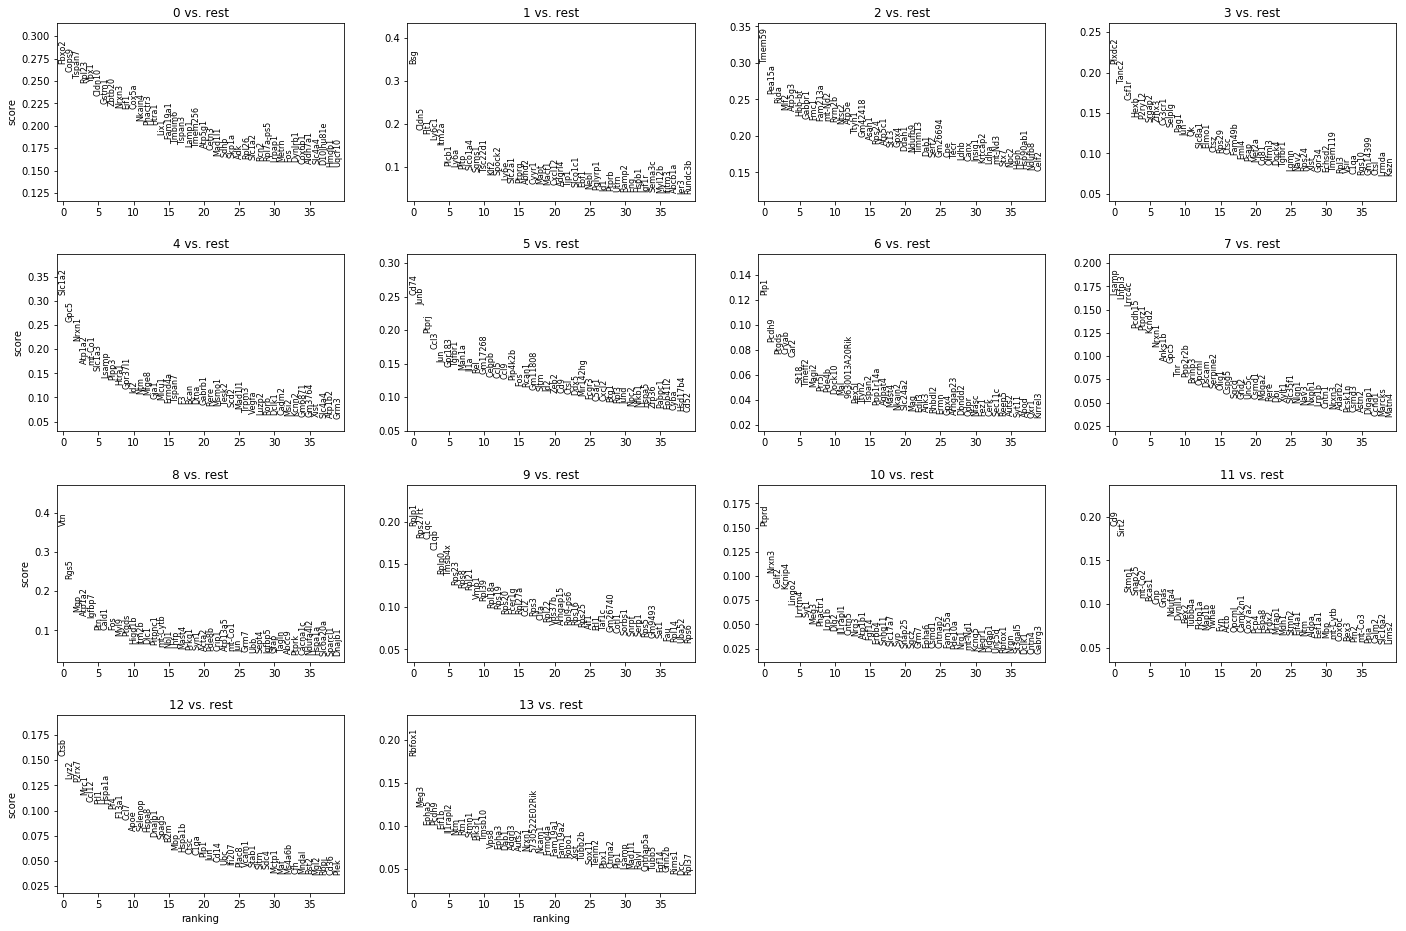

In [59]:
top = 40
sc.pl.rank_genes_groups(data, n_genes=top, sharey=False)

The above plots indicate that the first 5 to 8 genes seem to make the difference

In [60]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(8)

0      1       2       3       4       5       6       7       8  \
0   Fbxo2    Bsg  Tmem59  Plxdc2  Slc1a2    Cd74    Plp1   Lsamp     Vtn   
1   Cops9  Cldn5  Pea15a   Tanc2    Gpc5    Junb   Pcdh9  Lhfpl3    Rgs5   
2  Tspan7   Flt1    Rida   Csf1r   Nrxn1   Ptprj   Ptgds  Lrrc4c     Mgp   
3   Rpl23  Ly6c1    Mlf2    Hexb  Atp1a2    Ccl3   Cryab  Pcdh15  Atp1a2   
4    Ybx1  Itm2a  Atp5g3  P2ry12  mt-Co1     Jun    Car2  Ptprz1  Igfbp7   
5  Cldn10  Plcb1  Hbb-bt  Srgap2  Slc1a3  Gpr183    St18   Kcnd2     Ptn   
6   Gstm1   Ly6a  Gabbr1   Zfhx3   Lsamp  Tgfbr1  Tmeff2   Nrxn1   Cald1   
7  Zbtb20   Pltp    Fmc1  Cx3cr1   Plpp3   Man1a   Magi2  Anks1b     Fos   

         9      10      11      12        13  
0    Rplp1   Ptprd     Cd9    Ctsb    Rbfox1  
1  Rps27rt   Nrxn3   Sirt2    Lyz2      Meg3  
2     C1qc   Celf2   Stmn1   P2rx7     Epha5  
3     C1qb  Kcnip4  Snap25    Mrc1     Pcdh9  
4    Rplp0  Lingo2  mt-Co2   Ccl12     Eif1b  
5   Tmsb4x  Lrrtm4   Bcas1    Ftl1  Il1rapl2  
6    Rps23    Syt1     Cnp  Hspa1a       Ntm  
7     Rps8    Meg3    Gnas     Pf4      Rtn1

Look at the top transcription factors in each of the clusters. Note that `NaN` means "not a number", in other words an empty entry in the table.

In [61]:
top = 10

result = []
for colname, ranking in pd.DataFrame(data.uns['rank_genes_groups']['names']).iteritems():
    result.append(pd.Series([gname for gname in ranking if gname in transfac_genes]))
transfac_marker_genes = pd.concat(result, axis=1)[:top]
transfac_marker_genes

0     1      2      3       4        5      6      7       8      9  \
0   Fos  Klf2  Taf13    Jun    Rorb     Junb   St18  Olig1     Fos  Taf1c   
1  Ugp2  Ebf1   Lsm4  Mef2a    Sox9      Jun  Enpp2   Sox6     Jun   Klf2   
2   NaN  Klf4    NaN   Fli1     Fos      Rel   Ank2   Sox5  Notch3  Hmgb2   
3   NaN  Tcf4    NaN   Junb   Trps1    Cebpb  Sox10  Npas3    Rora    NaN   
4   NaN   NaN    NaN    NaN    Rora      Fos    NaN    NaN    Egr1    NaN   
5   NaN   NaN    NaN    NaN  Notch2    Nfkb1    NaN    NaN    Hes1    NaN   
6   NaN   NaN    NaN    NaN     NaN    Zfp36    NaN    NaN    Junb    NaN   
7   NaN   NaN    NaN    NaN     NaN  Tnfaip3    NaN    NaN    Fosb    NaN   
8   NaN   NaN    NaN    NaN     NaN    Nupr1    NaN    NaN    Ebf1    NaN   
9   NaN   NaN    NaN    NaN     NaN   Hivep2    NaN    NaN     NaN    NaN   

      10     11       12      13  
0   Rora  Sirt2      Jun   Sox11  
1  Myt1l  Olig1      Maf    Pbx1  
2    NaN    NaN      Fos    Sox4  
3    NaN    NaN     Fosb   Mllt3  
4    NaN    NaN  Zfp36l1    Ank2  
5    NaN    NaN    Hdac9    Pbx3  
6    NaN    NaN     Mid1   Fmnl2  
7    NaN    NaN      NaN  Hmgcs1  
8    NaN    NaN      NaN     NaN  
9    NaN    NaN      NaN     NaN

Selecting the top 3 transcription factors of each cluster (3 * 14 = 42 genes, minus duplicates) for visualisation.

    using 'X_pca' with n_pcs = 23
Storing dendrogram info using `.uns['dendrogram_louvain']`


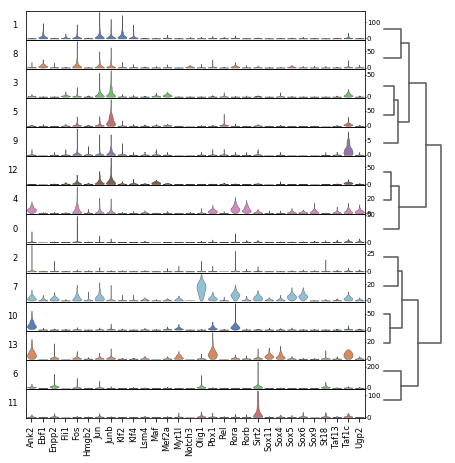

In [62]:
tmp = transfac_marker_genes.head(3).values.flatten().tolist()
# Remove 'nan' values
tmp = sorted(set([x for x in tmp if str(x) != 'nan']))

sc.tl.dendrogram(data, groupby='louvain', n_pcs=pcs_used, linkage_method='ward')
axes = sc.pl.stacked_violin(data, tmp, groupby='louvain', dendrogram=True, figsize=(7.5, 7.5));

Save the violinplot

In [63]:
fig = axes[0].get_figure()
fig.savefig(os.path.join(FIGURES_PATH, 'violin_transfac_louvain_clusters_{}.pdf'.format(timestamp())))

<div class="alert alert-block alert-danger">
    If you compare the above violin plot to the dot plot and the matrix plot below, you see that the dendrograms are mirrored... one of the two is wrong. I think the violin plot is wrong. 
</div>

We can also get the result visualized as a *dotplot*.

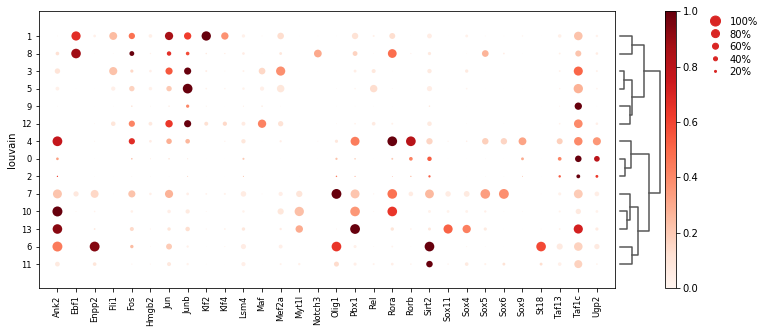

In [64]:
ax = sc.pl.dotplot(data, tmp, groupby='louvain', dendrogram=True, standard_scale='group')

And we can get the result visualized as a *matrixplot*.

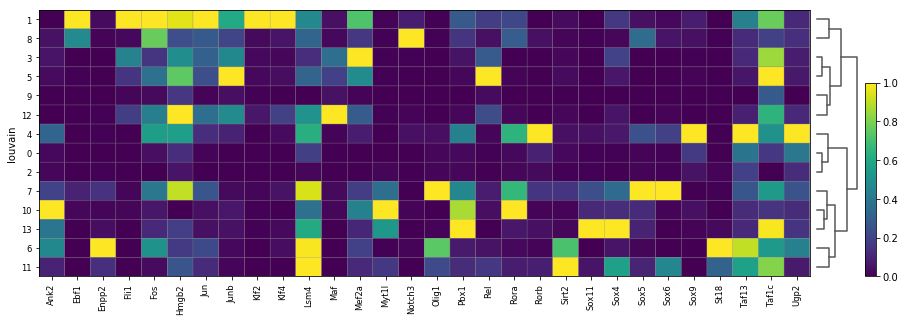

In [65]:
ax = sc.pl.matrixplot(data, tmp, groupby='louvain', dendrogram=True, standard_scale='var', figsize=(15, 5))

Some observations (please be aware that cluster labels change easily with changes in parameters):

- Junb splits the data set into two. Junb is high in clusters 3, 5, and 12; still appears in 1 and 8, and is hardly present in the others.
- Olig1 defines cluster 7.
- Kf2 defines cluster 1.
- Fos defines cluster 8.

- Cluster 0 and 2 are very alike, defined by Taf13, Taf1c, and Ugp2.
- Cluster 6 and 11 are alike on the basis of Sirt2.

# Defining the clusters using known markers

<div class="alert alert-block alert-warning">
    Below I have listed many known marker genes harvested from the scientific literature. Add your own genes as you see fit!
</div>

#### Arteries and other blood vessels

In [66]:
VASCULAR = ['Acta2', 'Cd93', 'Cldn5', 'Cxcl12', 'Tagln']

#### Macrophages that direct the immune response in the CNS

In [67]:
MICROGLIAL = ['Aif1', 'C1qa', 'Ctss', 'Cx3cr1', 'Gpr34', 'Hexb', 'Mrc1', 
    'P2ry12', 'Tmem119']

#### Astrocytes link neurons to blood supply, clean up neurotransmitter

In [68]:
ASTROCYTE = ['A2m', 'Aldh1l1', 'Clcn3', 'Fst', 'Gab1', 'Gfap', 'Glis3', 
    'Itih5', 'Ogn', 'Osmr', 'Ppp1r15a', 'Rad23b', 'Rdh10', 'Rnf13', 'Rsph9',
    'S100a6', 'Tgfbr2', 'Tril']

#### Oligodendrocytes wrap nerve fibres with myelin sheath

In [69]:
OLIGODENDROCYTE = ['Cldn11', 'Cpm', 'Enpp6', 'Fa2h', 'Gjc2', 'Gsn', 
    'Mag', 'Mal', 'Mbp', 'Mobp', 'Mog', 'Olig1', 'Olig2', 'Sox10']

#### Neuronal genes specific to the piriform cortex taken from *Diodato et al. 2015 Nat Comm*.

In [70]:
PIRIFORM_NEURON = ['Btbd3', 'Cacna1s', 'Cartpt', 'Cbx6', 'Dpf1', 'Fgfr2', 
    'Foxp2', 'Id1', 'Id4', 'Kcng1', 'Lmo3', 'Lrp4', 'Mical1', 'Neurod6', 'Otx1', 
    'Prdm8', 'Prrx1', 'Pvalb', 'Reln', 'Robo4', 'Sema3a', 'Slc13a3', 'Slc22a8', 
    'Sst', 'Vamp5', 'Zic1']

#### Neuronal marker genes, mostly studied in neocortical areas.

In [71]:
NEURON = ['Bcl11a', 'Bcl11b', 'Cdh8', 'Cnih3', 'Crh', 'Cux1', 'Dach2', 
    'Epha7', 'Fezf2', 'Foxp2', 'Gabra1', 'Gabra5', 'Gabrg2', 'Gda', 'Glra2', 
    'Gpr88', 'Htr2c', 'Kcng1', 'Kcnip4', 'Lmo4', 'Lrrtm4', 'Mal2', 'Mef2c', 
    'Meis2', 'Neurod6', 'Nfia', 'Nfix', 'Nov', 'Nr2e1', 'Nr2f2', 'Nts', 
    'Pbx3', 'Pcsk2', 'Pgm2l1', 'Plcxd3', 'Pou3f2', 'Prdm8', 'Pvalb', 
    'Rbfox3', 'Rfx3', 'Rorb', 'Satb1', 'Satb2', 'Sla', 'Slc12a5', 'Slc9a3r2',
    'Snap25', 'Sox4', 'Sox5', 'Sst', 'Stmn2', 'Syt1', 'Tbr1']

In [72]:
def plot_expression_on_umap(data, genenames, raw, columns=3):
    """
    Given a list of genes, plot in n columns the graph clusters with 
    gene expression mapped onto them. If raw is True, expression values 
    before normalization, scaling etc. are used.
    """   
    tmp = [x for x in genenames if x in data.raw.var_names]
    for i in range(0, len(tmp), columns):
        sc.pl.umap(data, color=tmp[i:(i+columns)], use_raw=raw)        
    # Report if gene not found
    if raw:
        np = [x for x in genenames if x not in data.raw.var_names]
    else:
        np = [x for x in genenames if x not in data.var_names]
    if np:
        print("Not present:", np)

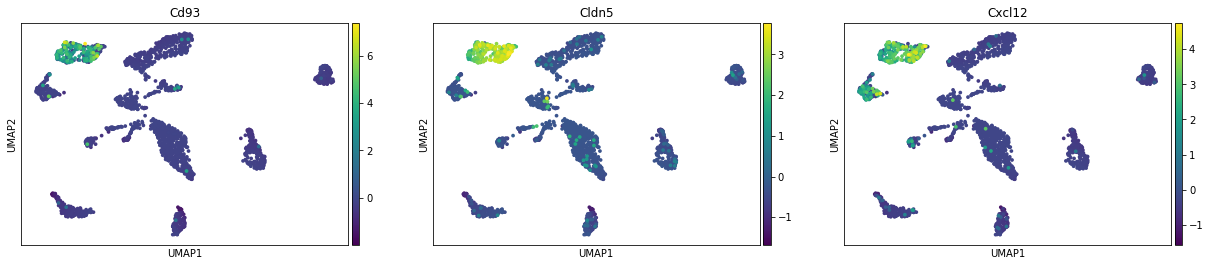

In [73]:
raw = False
plot_expression_on_umap(data, VASCULAR[1:-1], raw, 3)

Cluster 2 and perhaps also 10 appear vascular.

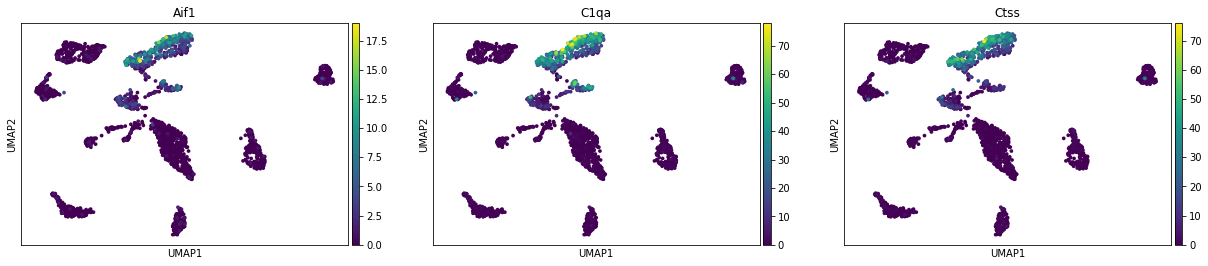

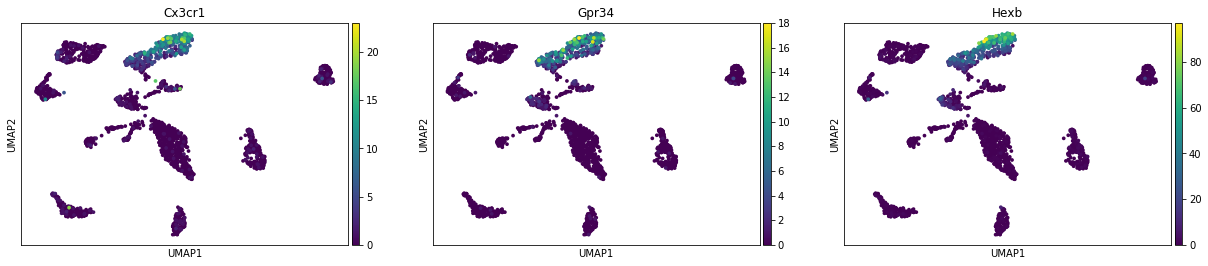

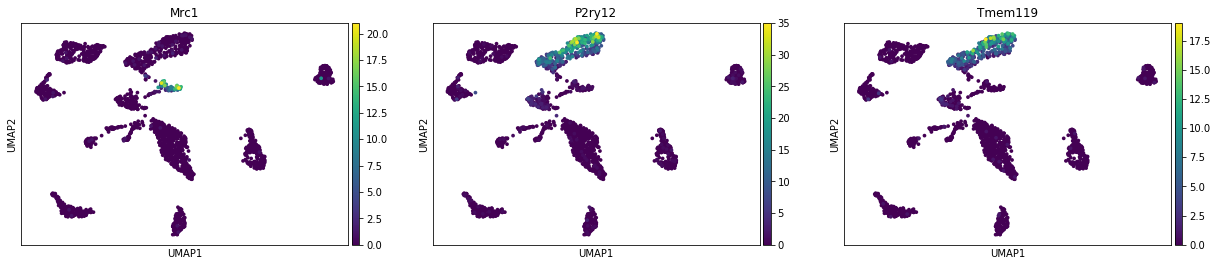

In [74]:
raw = True
plot_expression_on_umap(data, MICROGLIAL, raw, 3)

Cluster 1, 7, and 11 appear microglial. As we saw above, they are all defined by Junb. Cluster 9 is not microglial, though.

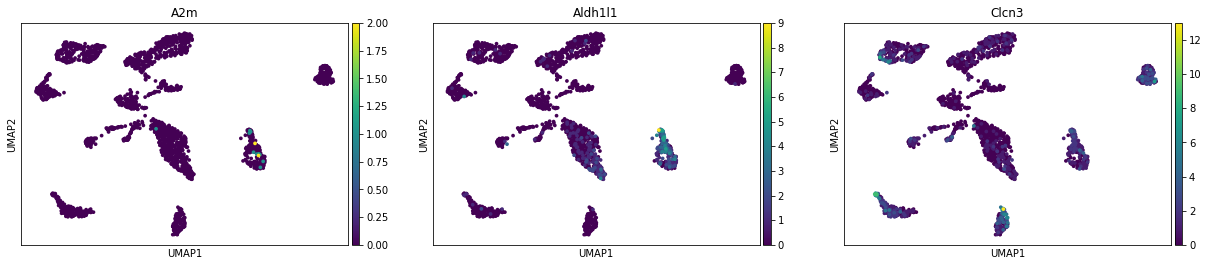

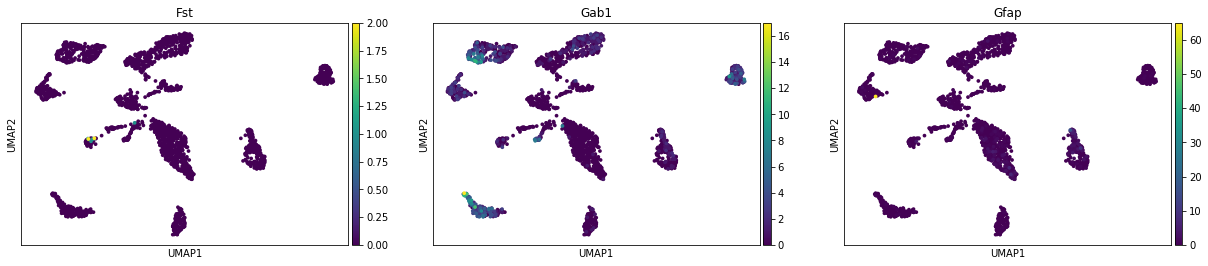

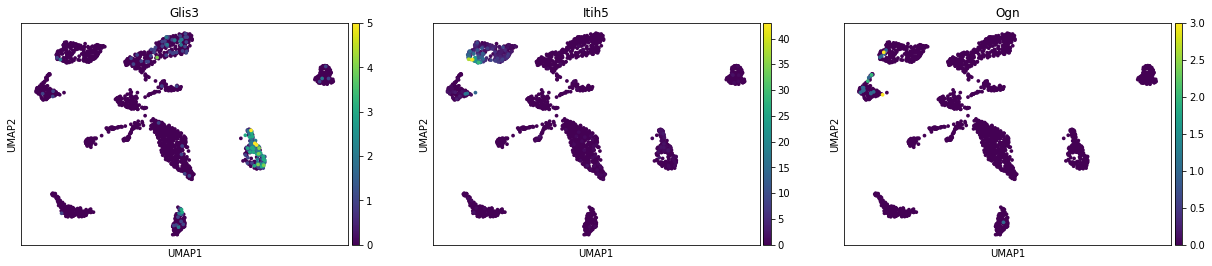

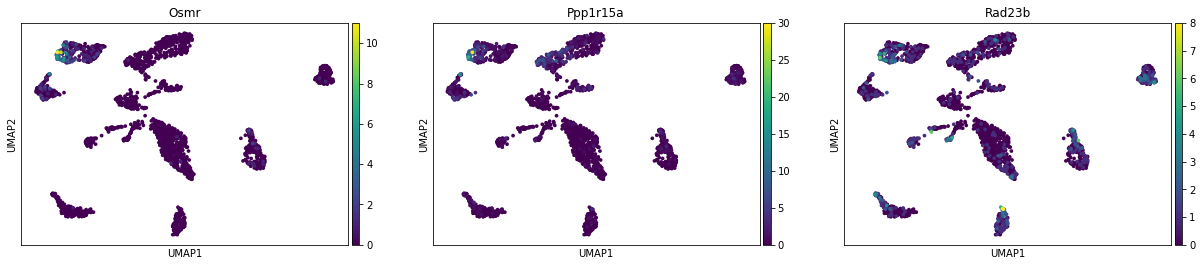

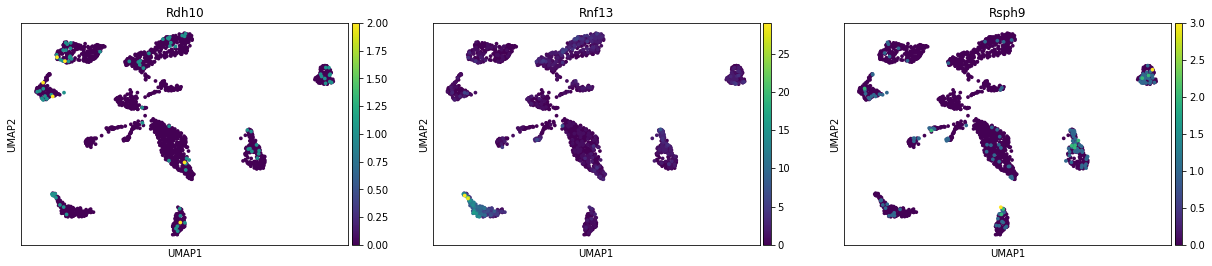

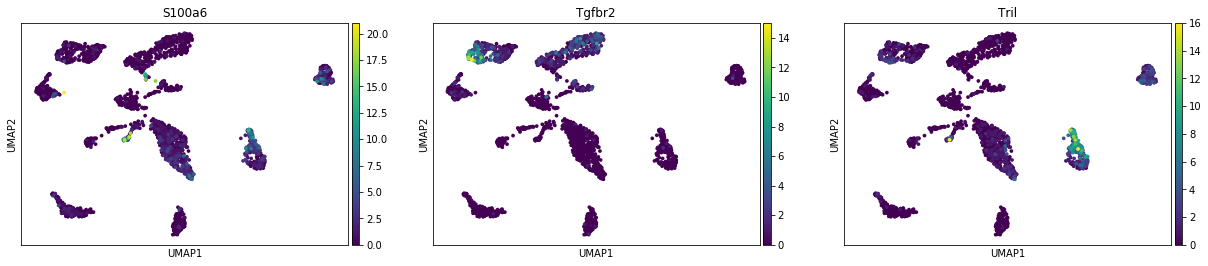

In [75]:
raw = True
plot_expression_on_umap(data, ASTROCYTE, raw, 3)

Astrocytes are more difficult to interpret. Cluster 4 seems a "yes", and perhaps cluster 7 too.

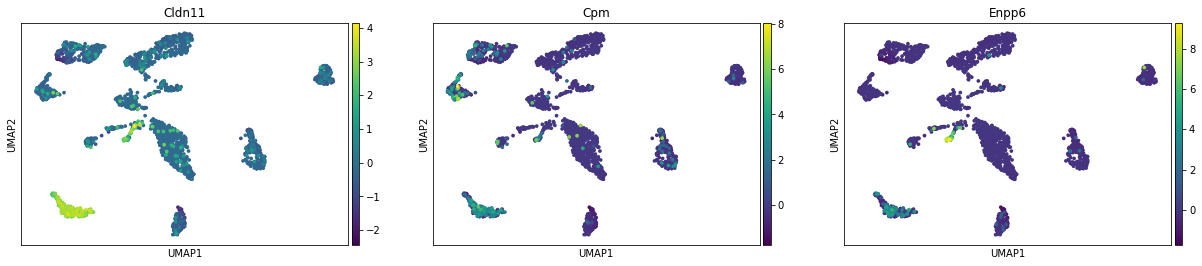

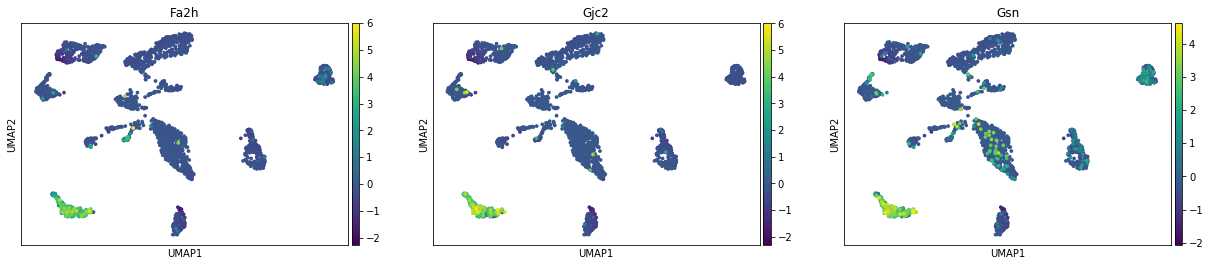

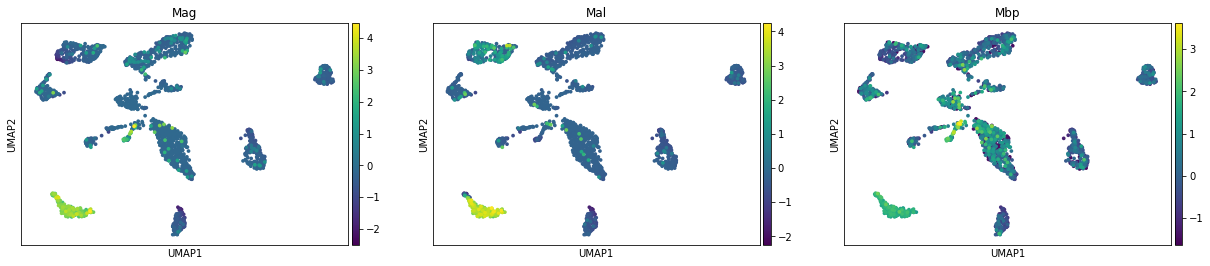

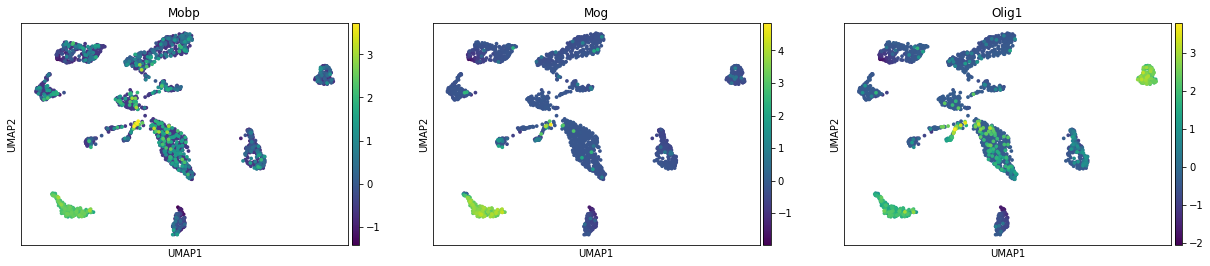

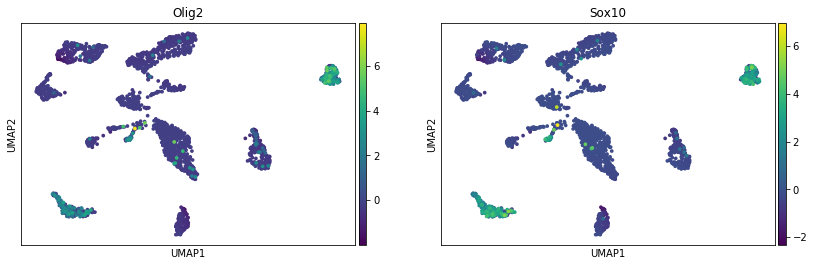

In [76]:
raw = False
plot_expression_on_umap(data, OLIGODENDROCYTE, raw, 3)

Two very distinct groups of oligodendrocytes: clusters 5 and 8. And easily missed is cluster 13...

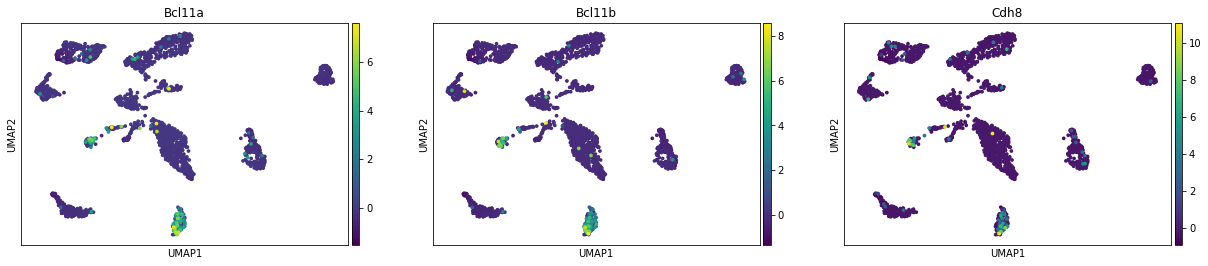

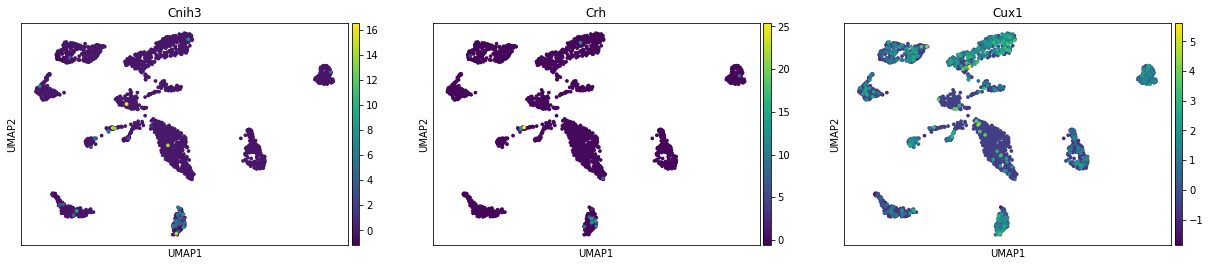

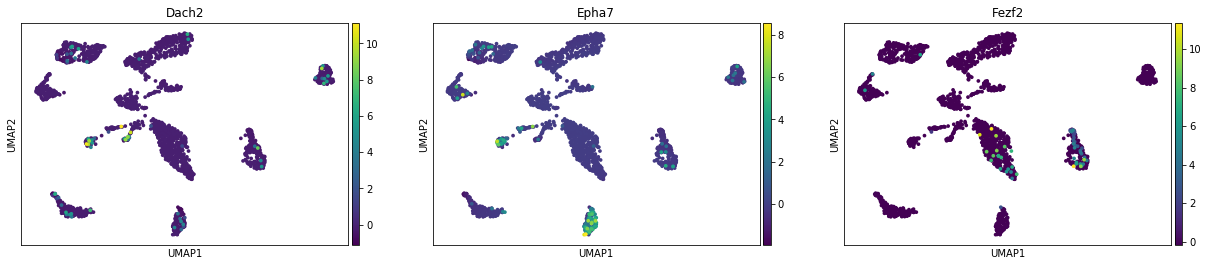

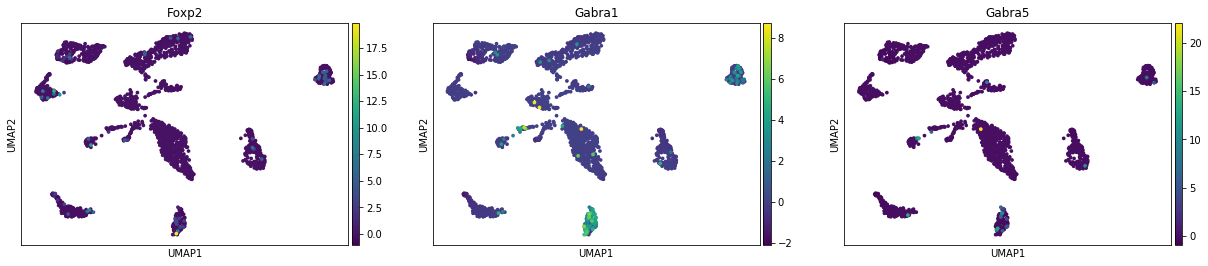

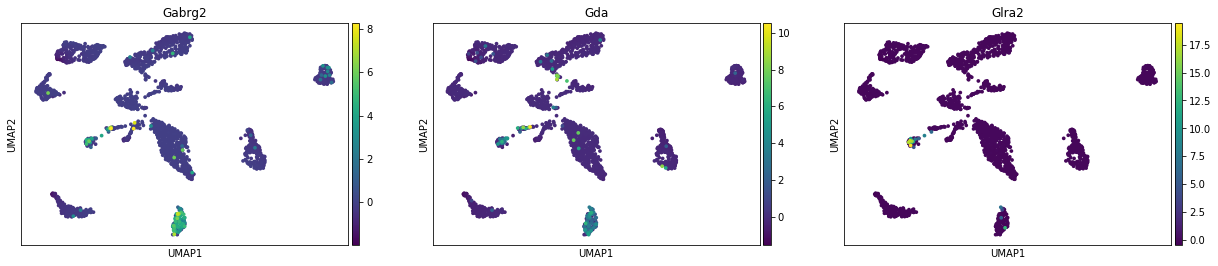

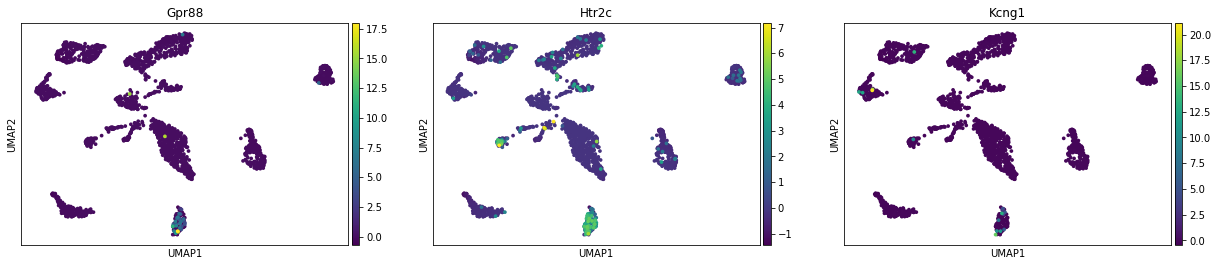

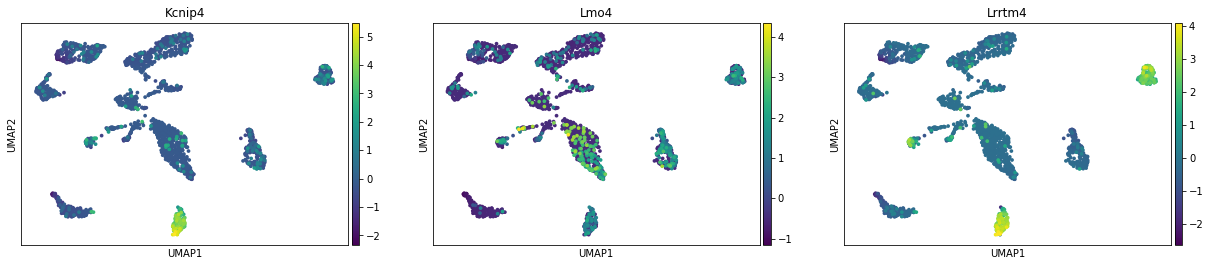

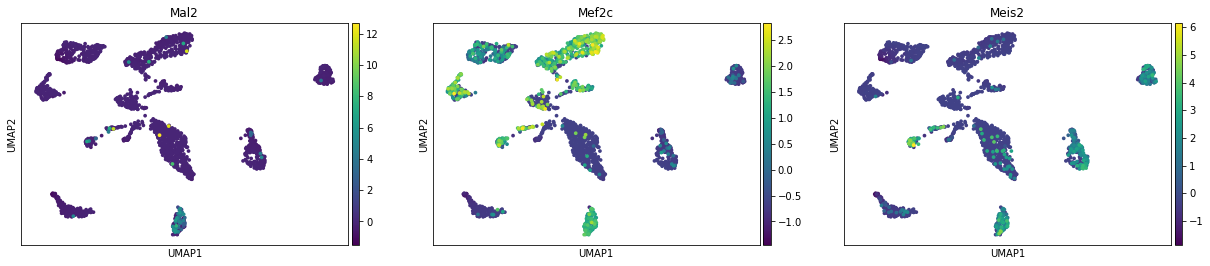

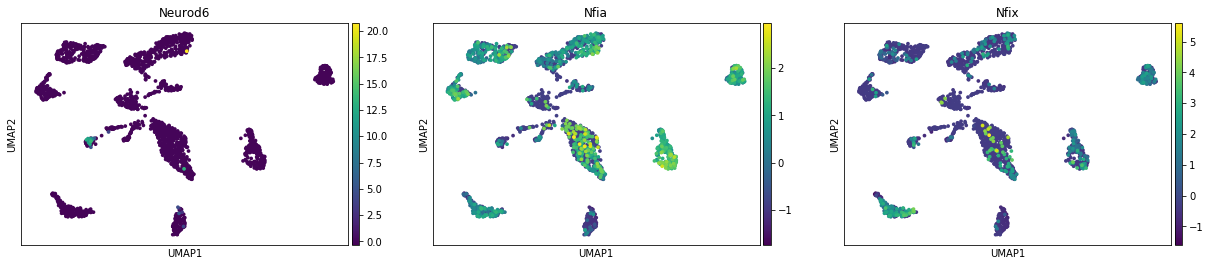

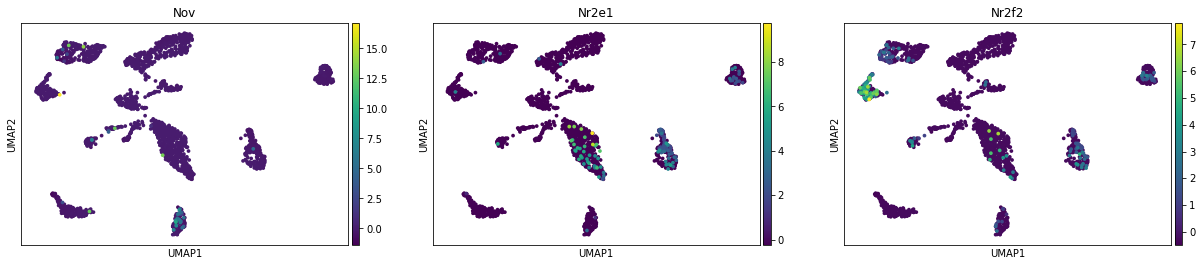

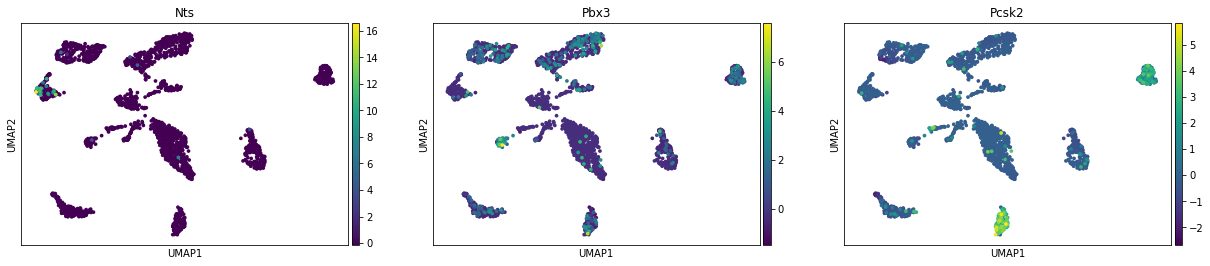

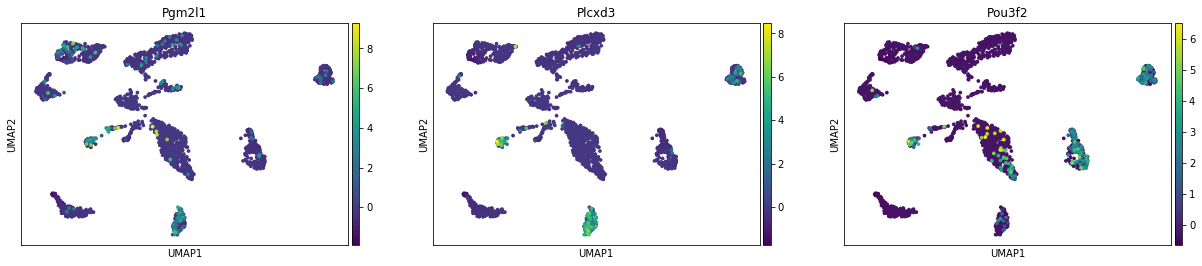

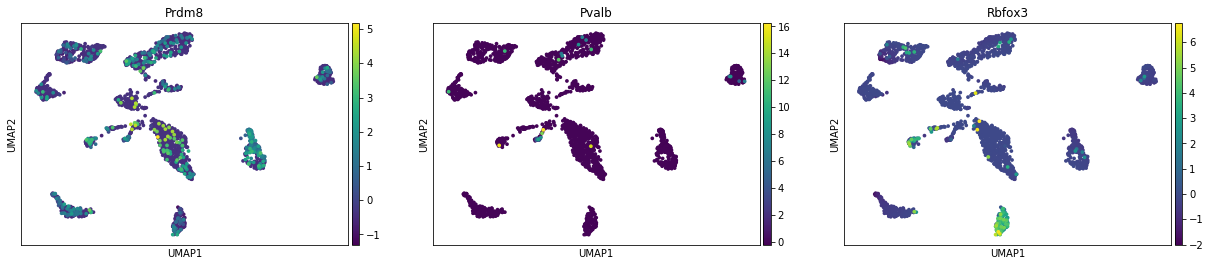

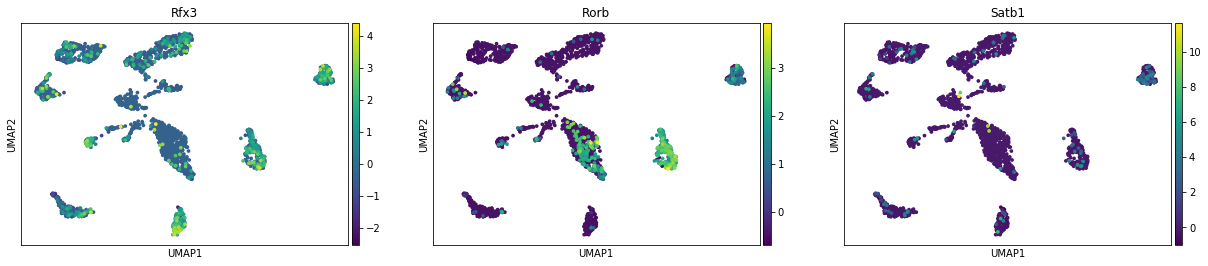

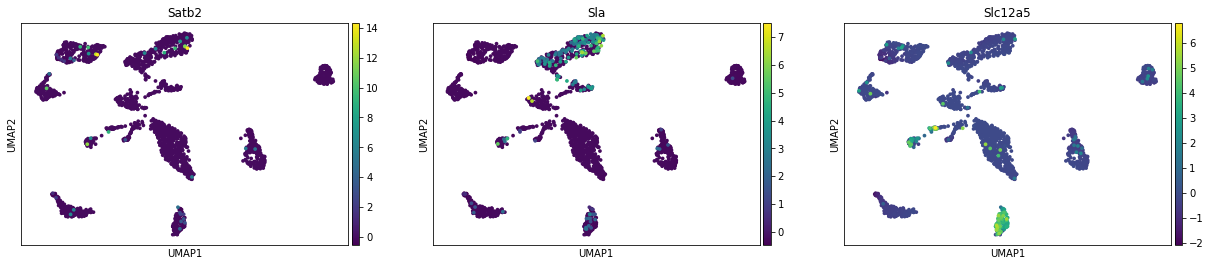

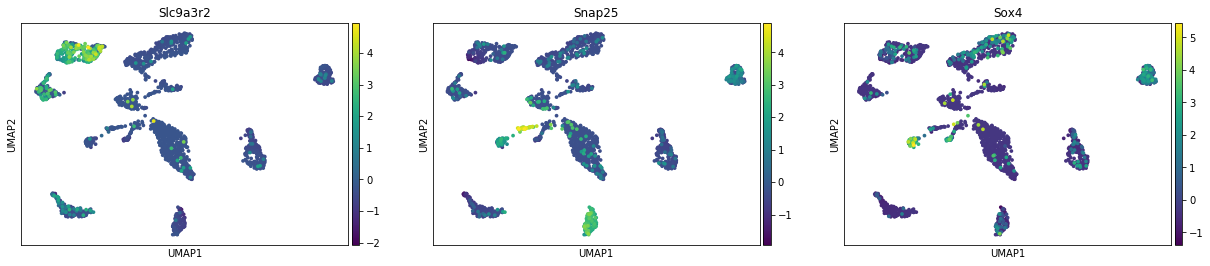

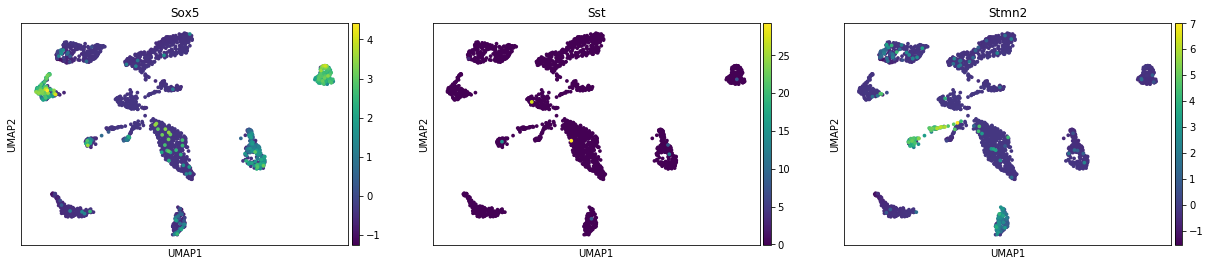

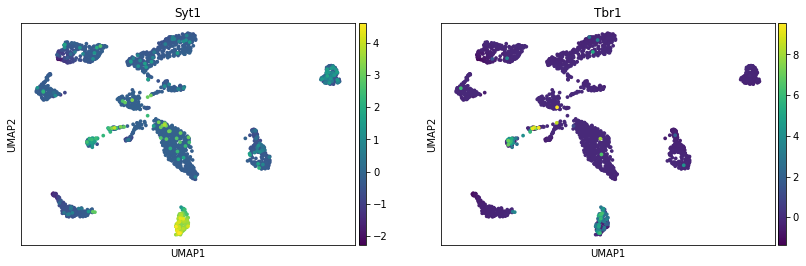

In [77]:
raw = False
plot_expression_on_umap(data, NEURON, raw, 3)

## Looking for stem cells and other progenitors

Marker genes were taken from *Shibata et al. 2015*. Note that I have added *Sox9* myself, it was not in the article. It overlaps very nicely with the others!

In [78]:
MAINTENANCE_PROGENITOR = ['Emx1', 'Emx2', 'Foxg1', 'Hes1', 'Hes5', 'Lhx2', 'Pax6', 'Sox9']

Note below that *Neurog1,2* = *Ngn1,2* and both are hardly expressed.

In [79]:
EARLY_PROGENITOR = ['Fezf2', 'Id4', 'Ngn1', 'Ngn2', 'Nr2e1']

Note below that *Tbr2* is not in the data, and *Tfap2c* has been filtered out during preprocessing.

In [80]:
LATE_PROGENITOR = ['Cux1', 'Cux2', 'Pou3f2', 'Pou3f3', 'Tbr2', 'Tfap2c', 'Insm1']

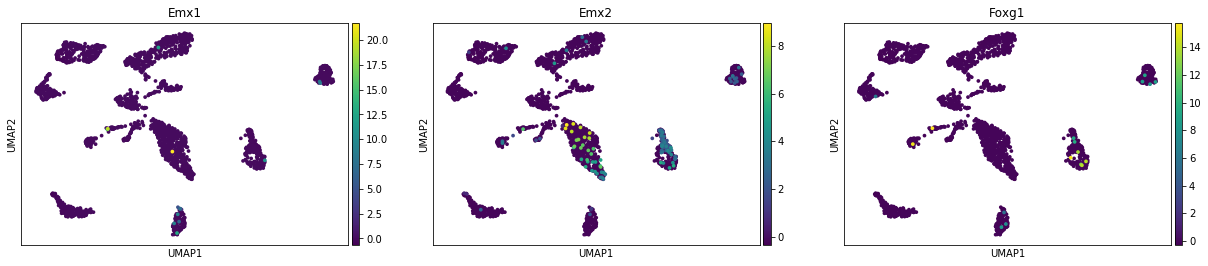

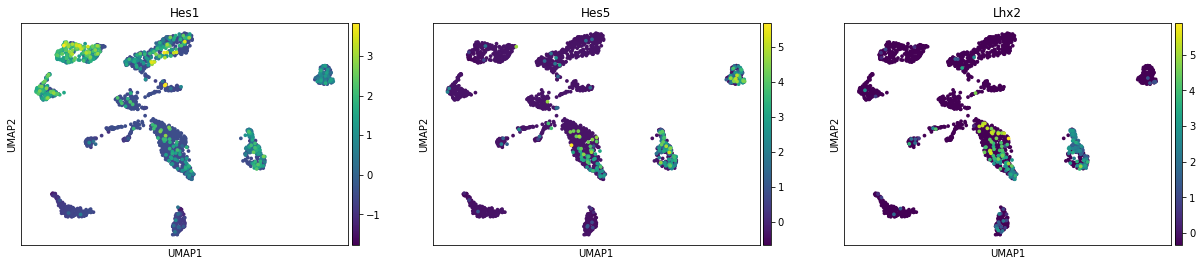

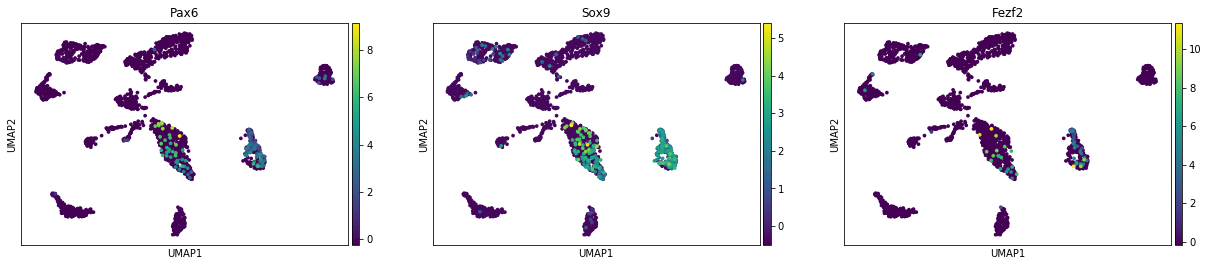

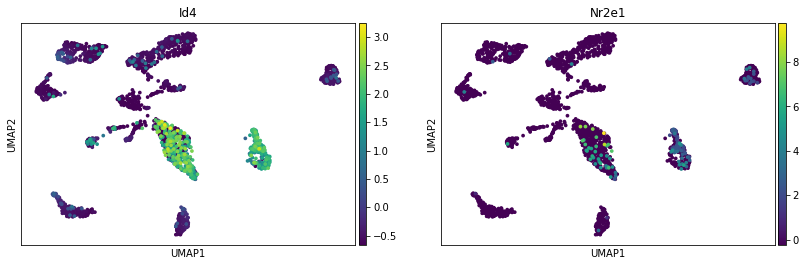

Not present: ['Ngn1', 'Ngn2']


In [81]:
plot_expression_on_umap(data, MAINTENANCE_PROGENITOR + EARLY_PROGENITOR, False, 3)

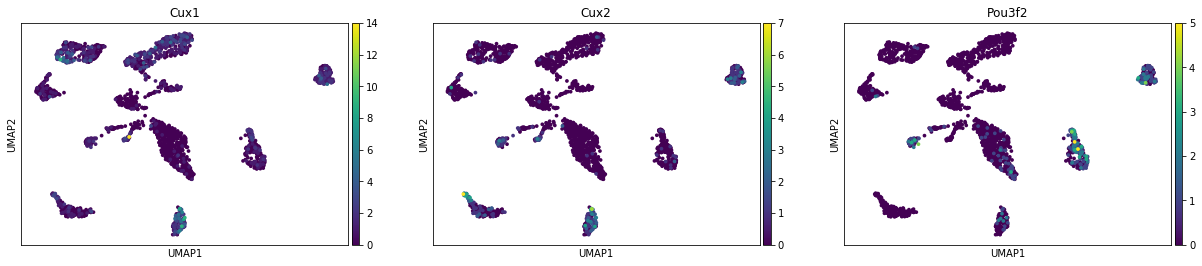

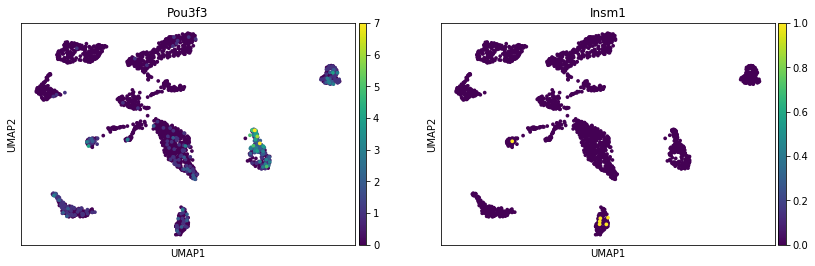

Not present: ['Tbr2', 'Tfap2c']


In [82]:
plot_expression_on_umap(data, LATE_PROGENITOR, True, 3)

Cluster 0 and 2 are probably a progenitor pool.

# Defining the cell types

In case the naming of cell types below is not clear, I use the following semi-controlled vocabulary:

- progen: progenitor or stem cells
- vasc: vascular cells
- mglial: microglial cells
- astro: astrocytes
- oligo: oligodendrocytes
- neuro: neurons

And I add a question mark (`?`) if I have doubts about the cell type label.

In [83]:
new_cluster_names = [
    '0:progen', '1:vasc', '2:progen', '3:mglial',
    '4:astro:progen', '5:mglial', '6:oligo', '7:astro?:oligo?',
    '8:vasc', '9:?', '10:neuro', '11:oligo',
    '12:mglial', '13:neuro']
data.rename_categories('louvain', new_cluster_names)

In [84]:
def plot_named_louvain_clusters(data, cluster_names=None, suffix='celltype.pdf'):
    """Hack cluster colours. Add names, if given, to the labels."""
    if cluster_names is not None:
        # Old-fashioned way of updating category names
        data.obs['louvain'].cat.categories = cluster_names

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sc.pl.umap(data, size=35, color='louvain', legend_loc='on data', 
        save='_{}_{}'.format(timestamp(), suffix), ax=ax)

As a side effect, the plotting function saves the figure. If you do not change `suffix`, the figure is saved as a PDF.

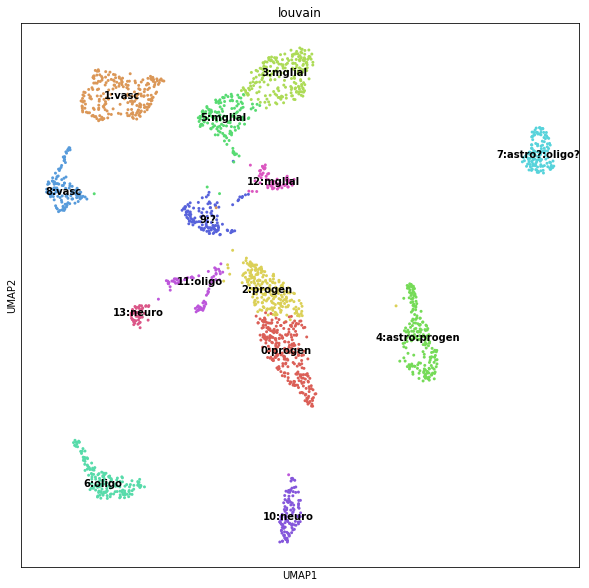

In [85]:
plot_named_louvain_clusters(data)

### Saving all our hard work

In [86]:
out_fname = 'scanpy_mouse_piriform_cell_v3_{}.h5ad'.format(timestamp())
data.write(out_fname, compression='gzip')

... storing 'feature_types' as categorical


# Zooming in on the neuronal clusters

<div class="alert alert-block alert-danger">
    </br>
    <b> ALERT </b>
    </br>
    Adjust the file name below (`out_fname`) to the timestamp that was used!
    </br>
    </br>
    </div>
    

In [88]:
#data = sc.read(out_fname)
data = sc.read('scanpy_mouse_piriform_cell_v3_2019-10-09_01h17.h5ad')

In [89]:
def focus_on_clusters(clustered_data, input_path, focal_name="neuro"):
    """
    Re-read data, select only those cells that we want (i.e. neurons).
    """
    zoom = clustered_data[
        clustered_data.obs['louvain'].str.contains(focal_name), :]

    data = sc.read_10x_mtx(input_path, make_unique=True, cache=False)
    data = data[zoom.obs.index]
    return data

In [90]:
data = focus_on_clusters(data, PIRIF_PATH)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Check if all went ok by printing the *data* object.

In [91]:
print(data)

View of AnnData object with n_obs × n_vars = 160 × 31053 
    var: 'gene_ids', 'feature_types'


Filtering out genes that are hardly expressed

In [92]:
sc.pp.filter_genes(data, min_cells=2)

filtered out 16608 genes that are detectedin less than 2 cells


Trying to set attribute `.var` of view, making a copy.


Normalize as always

In [93]:
data = normalize_and_log(data)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


<div class="alert alert-block alert-warning">
    Modify the number of bins below, if you get the message that there are many "single genes per bin". It usually means that you should reduce <var>n_bins</var>.
</div>

extracting highly variable genes
    Gene indices [14040, 14427, 14433] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:00)


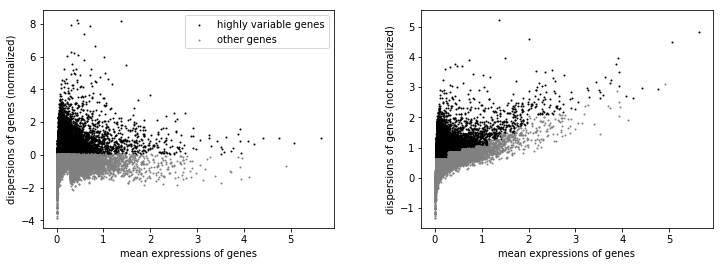

In [94]:
n_bins = 20
min_mean, max_mean, min_disp = 0.0, 10.0, 0.05
result = filter_by_expr_dispersion(data, min_mean, max_mean, min_disp, n_bins, dry_run=True)

Do the actual filtering, above was just a test run.

In [95]:
data = filter_by_expr_dispersion(data, min_mean, max_mean, min_disp, n_bins, dry_run=False)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [96]:
sc.pp.scale(data)

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:00)


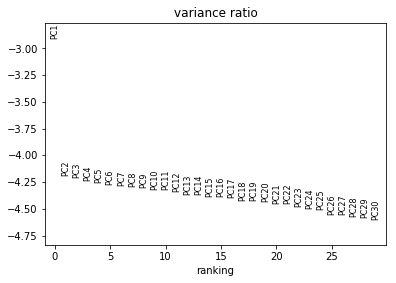

In [97]:
sc.tl.pca(data, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(data, log=True, save=False)

Below I pick just one principal component, which is a bit extreme.

In [98]:
pcs_used = 1

<div class="alert alert-block alert-warning">
    Given that we have fewer cells/nuclei now, it can be interesting to modify the neighbors <var>nbs</var> value below.
</div>

In [99]:
nbs = 15
sc.pp.neighbors(data, n_pcs=pcs_used, n_neighbors=nbs)
sc.tl.louvain(data)

computing neighbors
    using 'X_pca' with n_pcs = 1
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Show three 2D projections of the cells and colour them by Louvain clusters. Again, modify `seed` and `dotsize` to adjust the projections to your liking.

computing tSNE
    using 'X_pca' with n_pcs = 1
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)


... storing 'feature_types' as categorical


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


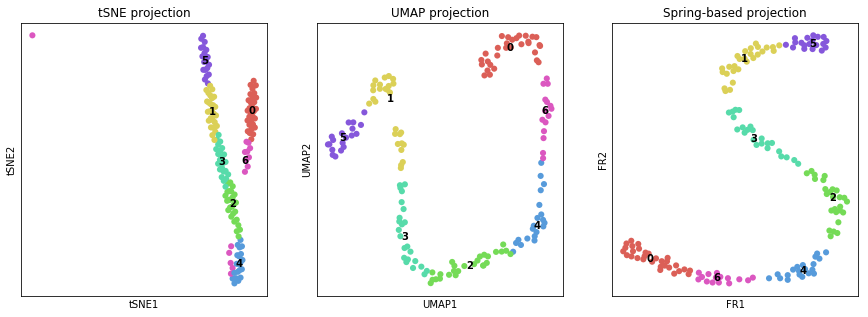

In [100]:
seed = 18
dotsize = 150
fig, axes = plt.subplots(1, 3, figsize=(15, 5.02))
_ = plot_tsne(data, pcs_used, seed, dotsize, axes[0])
_ = plot_umap(data, seed, dotsize, axes[1])
_ = plot_graph(data, seed, dotsize, axes[2])

In [101]:
fig.savefig(os.path.join(FIGURES_PATH, 'three_projections_with_louvain_clusters_neurons_only.pdf'))

# Looking for neuronal marker genes in the data

Note that I do not use any literature here. In this analysis, the marker genes are simply those genes that best identify a given cluster.

In [102]:
sc.tl.rank_genes_groups(data, 'louvain', method='logreg')

ranking genes


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:06)


As said above, it is an ugly, but informative plot of top n genes and their scores.

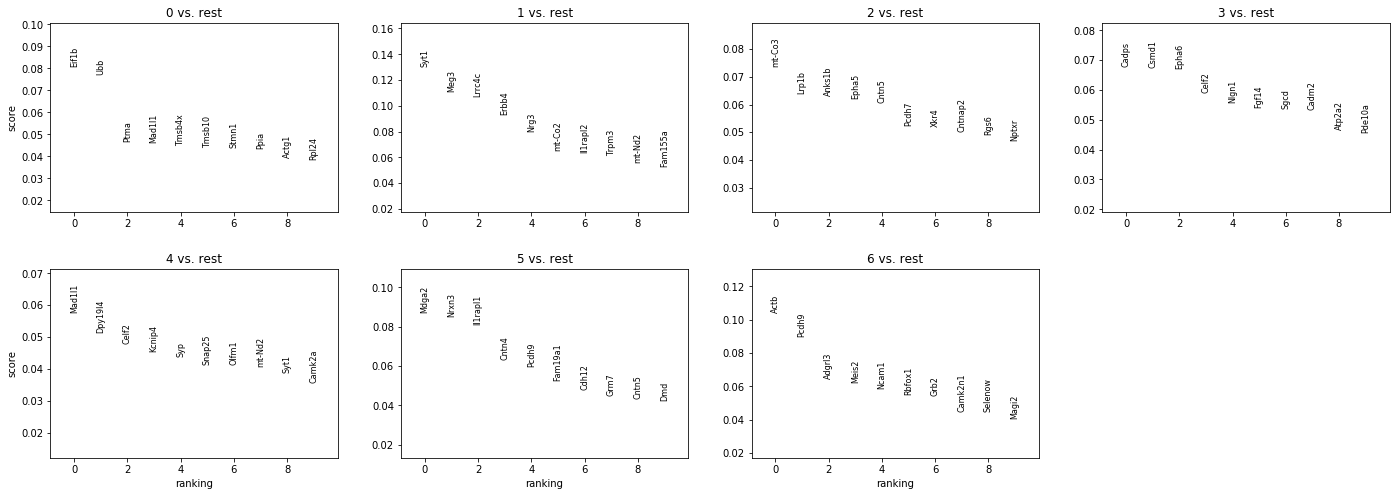

In [103]:
top = 10
sc.pl.rank_genes_groups(data, n_genes=top, sharey=False)

Looking at the top transcription factors in each of the clusters

In [104]:
top = 10

result = []
for colname, ranking in pd.DataFrame(data.uns['rank_genes_groups']['names']).iteritems():
    result.append(pd.Series([gname for gname in ranking if gname in transfac_genes]))
transfac_marker_genes = pd.concat(result, axis=1)[:top]
transfac_marker_genes

0       1       2      3       4      5       6
0     Ptma    Ank2   Nptxr  Myt1l    Rora  Npas3    Nfib
1    Basp1  Hivep3    Thra  Camk4  Pou3f3  Hdac9  Zfp523
2     Tcf4    Sox5  Hivep2    NaN    Chgb    NaN   Mef2c
3    Sox11     NaN    Thrb    NaN     NaN    NaN    Pbx1
4     Naca     NaN     NaN    NaN     NaN    NaN   Ncor1
5    Nr2f1     NaN     NaN    NaN     NaN    NaN     NaN
6  Smarca2     NaN     NaN    NaN     NaN    NaN     NaN

Single out the top 5 transcription factors of each cluster

In [105]:
tmp = transfac_marker_genes.head(5).values.flatten().tolist()

Remove 'nan' values

In [106]:
tmp = sorted(set([x for x in tmp if str(x) != 'nan']))

I commented out the code for making a dendrogram. With very few clusters a dendrogram does not really give us any extra insight.

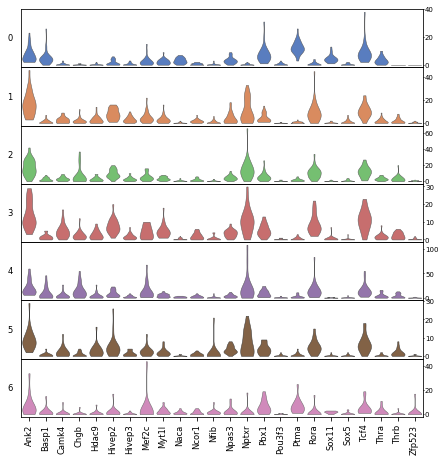

In [107]:
#sc.tl.dendrogram(data, groupby='louvain', n_pcs=pcs_used, linkage_method='ward')
axes = sc.pl.stacked_violin(data, tmp, groupby='louvain', dendrogram=False, figsize=(7.5, 7.5));

Save the violinplot

In [109]:
fig = axes[0].get_figure()
fig.savefig(os.path.join(FIGURES_PATH, 'violin_transfac_louvain_clusters_neurons_only.pdf'))

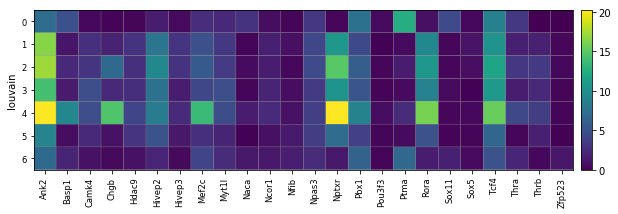

In [110]:
ax = sc.pl.matrixplot(data, tmp, groupby='louvain', dendrogram=False, figsize=(10, 3))

### Conclusion at the moment...

Zooming in on only neurons makes the space collapse to a single principal component (PC1)... so I should investigate how each of the genes contribute to PC1 (Have not done this yet).

Instead I searched for marker genes, i.e. genes that are differentially expressed between the clusters. Some common sense genes pop up, like *Sox5* and *Sox11* each defining a single cluster. Most of these genes will require some literature search, though.